In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

# import os
# if os.name == 'posix' :
#     plt.rc('font', family='AppleGothic')
# else :
#     plt.rc('font', family='Malgun Gothic')
    
plt.rc('axes', unicode_minus=False)

plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
# 검정을 위해 필요한 라이브러리
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro

# EDA

In [3]:
user_df = pd.read_parquet('./votes/accounts_user.parquet')
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [4]:
userquestion_df = pd.read_parquet('./votes/accounts_userquestionrecord.parquet')
userquestion_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [5]:
school_df = pd.read_parquet('./votes/accounts_school.parquet')
school_df.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [6]:
group_df = pd.read_parquet('./votes/accounts_group.parquet')
group_df.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [7]:
# school_id, group_id 테이블 합치기
school_group_df = pd.merge(group_df, school_df, left_on='school_id', right_on='id', how='left')
school_group_df = school_group_df.drop(columns=['class_num', 'id_y'])
school_group_df = school_group_df.rename(columns={'id_x':'group_id'})
school_group_df.head()

,group_id,grade,school_id,address,student_count,school_type
0,1,1,1,NaN,NaN,NaN
1,8,3,1,NaN,NaN,NaN
2,9,3,1,NaN,NaN,NaN
3,10,2,1,NaN,NaN,NaN
4,11,2,1,NaN,NaN,NaN


In [8]:
user_group_df = user_df[['id', 'group_id']]
user_school_df = pd.merge(user_group_df, school_group_df, on='group_id', how='left')
user_school_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,NaN,NaN,NaN,NaN,NaN,NaN
1,831962,12.0,2.0,1.0,NaN,NaN,NaN
2,832151,1.0,1.0,1.0,NaN,NaN,NaN
3,832340,1.0,1.0,1.0,NaN,NaN,NaN
4,832520,12.0,2.0,1.0,NaN,NaN,NaN


In [9]:
# 필요한 컬럼만 뽑기
userquestion_df = userquestion_df[['id', 'status', 'created_at', 'chosen_user_id', 'question_id', 'user_id', 'question_piece_id', 'has_read', 'answer_status']]
# user_id, school_id 모두 합치기
user_question_school_df = pd.merge(userquestion_df, user_school_df, left_on='user_id', right_on='id', how='left')
user_question_school_df.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,id_y,group_id,grade,school_id,address,student_count,school_type
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [10]:
# 가입 유저들과 학교 id 합치기
user_school_df = pd.merge(user_school_df, school_group_df, on='group_id', how='left')
user_school_df.head()

,id,group_id,grade_x,school_id_x,address_x,student_count_x,school_type_x,grade_y,school_id_y,address_y,student_count_y,school_type_y
0,831956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,831962,12.0,2.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN
2,832151,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
3,832340,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
4,832520,12.0,2.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN


## 투표율 구하기

In [11]:
# 해당 학생들로만 데이터 분석하기 위해서 user_id 리스트로 뽑기
user_list = list(user_question_school_df['user_id'].unique())
user_list

[849436,
 847375,
 849438,
 849479,
 849441,
 849452,
 849469,
 849439,
 849634,
 849489,
 849493,
 849692,
 849445,
 849670,
 849477,
 849762,
 849487,
 849475,
 849559,
 849864,
 849454,
 849446,
 849504,
 849566,
 849503,
 849471,
 849443,
 849558,
 849620,
 849497,
 849444,
 849543,
 849922,
 849466,
 849464,
 849442,
 849450,
 849103,
 849946,
 849451,
 849488,
 849490,
 849981,
 849983,
 849995,
 849974,
 850007,
 850006,
 849460,
 850039,
 850031,
 850058,
 850057,
 850077,
 849549,
 850091,
 850098,
 849498,
 849979,
 849548,
 849502,
 849512,
 850150,
 850112,
 850130,
 850173,
 850180,
 850186,
 849938,
 850195,
 850152,
 849535,
 850208,
 850212,
 850217,
 850215,
 849928,
 850248,
 850255,
 850229,
 849963,
 850267,
 850269,
 838642,
 850334,
 850344,
 850378,
 850303,
 849541,
 850429,
 850249,
 850127,
 850475,
 850457,
 850284,
 850102,
 850319,
 850388,
 850435,
 850554,
 850556,
 849453,
 850392,
 850412,
 849486,
 849515,
 850413,
 850615,
 850610,
 850633,
 850668,
 

In [12]:
# 누적 회원가입 구하기 위해서 우선 필요한 컬럼만 뽑기
user_join_df =  user_df[['id', 'created_at']]
user_join_df.head()

,id,created_at
0,831956,2023-03-29 03:44:14.047130
1,831962,2023-03-29 05:18:56.162368
2,832151,2023-03-29 12:56:34.989468
3,832340,2023-03-29 12:56:35.020790
4,832520,2023-03-29 12:56:35.049311


In [13]:
# 10개 학교 학생들로만 구성되도록 데이터 정제하기
# user_join_df = user_join_df[user_join_df['id'].isin(user_list)]
# 연-월-일 컬럼 뽑기
user_join_df['year_month_day'] = user_join_df['created_at'].dt.strftime('%Y-%m-%d')
user_join_df.head()

/tmp/ipykernel_1509767/3069608642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_join_df['year_month_day'] = user_join_df['created_at'].dt.strftime('%Y-%m-%d')


,id,created_at,year_month_day
0,831956,2023-03-29 03:44:14.047130,2023-03-29
1,831962,2023-03-29 05:18:56.162368,2023-03-29
2,832151,2023-03-29 12:56:34.989468,2023-03-29
3,832340,2023-03-29 12:56:35.020790,2023-03-29
4,832520,2023-03-29 12:56:35.049311,2023-03-29


In [14]:
# 일별 회원가입 수 확인
user_join_cnt_df = user_join_df.groupby(['year_month_day'])['id'].nunique().reset_index(name='daily_join_cnt')
# 누적 회원 수 컬럼 생성
user_join_cnt_df['total_user'] = user_join_cnt_df['daily_join_cnt'].cumsum()
user_join_cnt_df.head()
# 5~7월만 보기
# user_join_cnt_df = user_join_cnt_df[(user_join_cnt_df['year_month_day'] >= '2023-05-01') & (user_join_cnt_df['year_month_day'] < '2023-08-01')]
# user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user
0,2023-03-29,11,11
1,2023-03-31,22,33
2,2023-04-01,16,49
3,2023-04-02,1,50
4,2023-04-03,5,55


## 일별 투표한 유저수

In [15]:
# 연-월-일 컬럼 생성
user_question_school_df['year_month_day'] = user_question_school_df['created_at'].dt.strftime('%Y-%m-%d')
# 일별 투표자 수
daily_question_df = user_question_school_df.groupby(['year_month_day'])['user_id'].nunique()
daily_question_df.head()

year_month_day
2023-04-28    125
2023-04-29    221
2023-04-30    325
2023-05-01    325
2023-05-02    413
Name: user_id, dtype: int64

In [16]:
# 데이터프레임 형태로 만들어서 합치기
daily_question_df = daily_question_df.reset_index(name='daily_question_user_cnt')

user_join_cnt_df = pd.merge(user_join_cnt_df, daily_question_df,on='year_month_day', how='left')
user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt
0,2023-03-29,11,11,NaN
1,2023-03-31,22,33,NaN
2,2023-04-01,16,49,NaN
3,2023-04-02,1,50,NaN
4,2023-04-03,5,55,NaN


In [17]:
# 일별 투표율 구하기
user_join_cnt_df['vote_rate'] = user_join_cnt_df['daily_question_user_cnt'] / user_join_cnt_df['total_user']
user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate
0,2023-03-29,11,11,NaN,NaN
1,2023-03-31,22,33,NaN,NaN
2,2023-04-01,16,49,NaN,NaN
3,2023-04-02,1,50,NaN,NaN
4,2023-04-03,5,55,NaN,NaN


In [19]:
# 날짜 자르기
user_join_cnt_df = user_join_cnt_df[(user_join_cnt_df['year_month_day']>='2023-04-28')&(user_join_cnt_df['year_month_day']<'2023-08-01')]

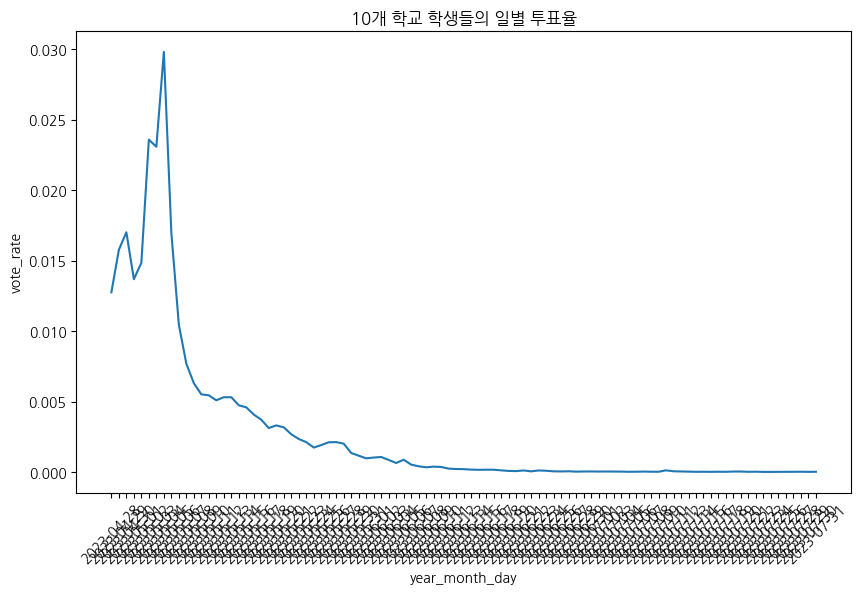

In [20]:
plt.figure(figsize=(10,6))
sns.lineplot(data=user_join_cnt_df,  x='year_month_day', y='vote_rate')
plt.title('10개 학교 학생들의 일별 투표율')
plt.xticks(rotation=45)
plt.show()

# 파생변수 만들기 

In [81]:
master_df = pd.read_csv('./add/master_last_v5.csv')
master_df.head()

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count,period_friend_count,retention_group
0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28,63.0,top25
1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6,6.0,top25
2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,369.0,1.0,930.0,69,45,16.0,top25
3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,369.0,1.0,838.0,259,55,69.0,top25
4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,369.0,2.0,1058.0,73,32,60.0,top25


In [82]:
# 유저 학교의 주소, 유저 학교의 학생 수, 유저 학교의 타입 정보 추가
adress_questioncategory_df = pd.merge(master_df, school_df, left_on='school_id', right_on='id',  how='left')
# 중복되는 학교 id 컬럼 삭제 
adress_questioncategory_df = adress_questioncategory_df.drop(columns=['id'])
adress_questioncategory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2507 non-null   int64  
 1   total_votes          2507 non-null   int64  
 2   unique_days          2507 non-null   int64  
 3   first_vote           2507 non-null   object 
 4   last_vote            2507 non-null   object 
 5   active_days          2507 non-null   int64  
 6   cohort_day           2507 non-null   object 
 7   retention_day8       2507 non-null   float64
 8   gender               2507 non-null   object 
 9   school_id            2507 non-null   float64
 10  grade                2507 non-null   float64
 11  group_id             2507 non-null   float64
 12  votes_within_3d      2507 non-null   int64  
 13  chosen_user_count    2507 non-null   int64  
 14  period_friend_count  2507 non-null   float64
 15  retention_group      2507 non-null   o

In [83]:
integrated_df = pd.read_csv('./master_last_v5.csv')
integrated_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,votes_within_3d,period_friend_count,retention_group,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,chosen_count
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,77,63.0,top25,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['스타일'],342.0
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,10,6.0,top25,충청남도 천안시 서북구,491,H,161,화목한 가정을 꾸릴거 같은 사람은?,['인간관계'],40.0
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,69,16.0,top25,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['상상'],309.0
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,259,69.0,top25,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['스타일'],256.0
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,73,60.0,top25,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['스타일'],201.0


In [84]:
# 심층 분석에 해당하는 유저 리스트
user_list = list(integrated_df['user_id'].unique())

In [86]:
# 투표 기록 테이블
userquestionrecord_df = pd.read_parquet('votes/accounts_userquestionrecord.parquet') 
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [87]:
# 기간 자르기
userquestionrecord_chosen_df = userquestionrecord_df[(userquestionrecord_df['created_at']>='2023-04-28')& (userquestionrecord_df['created_at']<'2023-08-01')]
# 심층 분석 유저 데이터만 남기기
userquestionrecord_chosen_df = userquestionrecord_chosen_df[userquestionrecord_chosen_df['chosen_user_id'].isin(user_list)]

# 유저 별 투표 받은 수 확인하기
userquestionrecord_chosen_df = userquestionrecord_chosen_df.groupby(['chosen_user_id']).size().reset_index(name='chosen_count')
userquestionrecord_chosen_df.head()

,chosen_user_id,chosen_count
0,838466,342
1,838642,40
2,840512,309
3,840685,256
4,840902,201


In [88]:
# 마스터 테이블과 합치기
integrated_v5_df = pd.merge(integrated_df, userquestionrecord_chosen_df, left_on='user_id', right_on='chosen_user_id', how='left')
integrated_v5_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,retention_group,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,chosen_count_x,chosen_user_id,chosen_count_y
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,top25,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['스타일'],342.0,838466.0,342.0
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,top25,충청남도 천안시 서북구,491,H,161,화목한 가정을 꾸릴거 같은 사람은?,['인간관계'],40.0,838642.0,40.0
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,top25,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['상상'],309.0,840512.0,309.0
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,top25,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['스타일'],256.0,840685.0,256.0
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,top25,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['스타일'],201.0,840902.0,201.0


In [89]:
# 필요없는 컬럼 삭제
integrated_v5_df = integrated_v5_df.drop(columns=['chosen_user_id'])

# 리텐션 차트

In [21]:
# 유저별 투표 횟수 확인해보기
user_vote_cnt_df = user_question_school_df.groupby(['user_id']).size().reset_index(name='vote_cnt')
user_vote_cnt_df['vote_cnt'].describe()

count    4849.000000
mean      251.094659
std       229.023228
min         1.000000
25%        93.000000
50%       190.000000
75%       338.000000
max      2786.000000
Name: vote_cnt, dtype: float64

In [22]:
# 유저별 투표 일자 확인
grouped = user_question_school_df.groupby(['user_id', 'year_month_day']).size().reset_index(name='count')

In [23]:
# 유저별 몇번째 투표일인지 나타내기
grouped['visit_order'] = (
    grouped
    .groupby('user_id')
    .cumcount() + 1
)

In [24]:
# 재투표인 사람들만 확인하기
visit_again_df = grouped[grouped['visit_order'] > 1]

# 재투표 유저 데이터만 모아둔거에서, 일자별로 몇명이 재투표한건지 확인해보기
visit_again_df = visit_again_df.groupby(['year_month_day'])['user_id'].nunique().reset_index(name='visit_again_cnt')
visit_again_df.head()

,year_month_day,visit_again_cnt
0,2023-04-29,122
1,2023-04-30,211
2,2023-05-01,289
3,2023-05-02,341
4,2023-05-03,373


In [25]:
# 투표율 데이터프레임에 합치기
user_cnt_df = pd.merge(user_join_cnt_df, visit_again_df, on='year_month_day', how='left')
user_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate,visit_again_cnt
0,2023-04-28,1181,9794,125.0,0.012763,NaN
1,2023-04-29,4213,14007,221.0,0.015778,122.0
2,2023-04-30,5086,19093,325.0,0.017022,211.0
3,2023-05-01,4640,23733,325.0,0.013694,289.0
4,2023-05-02,4071,27804,413.0,0.014854,341.0


In [26]:
# 5/1은 데이터 분석 기간의 첫 날이므로 재투표율이 없는게 당연하여서 결측치 0으로 채움
# visit_again_cnt 의 결측치는 5/1 하루 뿐임
user_cnt_df['visit_again_cnt'] = user_cnt_df['visit_again_cnt'].fillna(0)
user_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate,visit_again_cnt
0,2023-04-28,1181,9794,125.0,0.012763,0.0
1,2023-04-29,4213,14007,221.0,0.015778,122.0
2,2023-04-30,5086,19093,325.0,0.017022,211.0
3,2023-05-01,4640,23733,325.0,0.013694,289.0
4,2023-05-02,4071,27804,413.0,0.014854,341.0


In [27]:
# 재투표 비율 구해보기
# 전체 투표한 유저 중 첫 투표가 아닌 유저 비율
user_cnt_df['again_rate'] = user_cnt_df['visit_again_cnt'] /  user_cnt_df['daily_question_user_cnt']
user_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate,visit_again_cnt,again_rate
0,2023-04-28,1181,9794,125.0,0.012763,0.0,0.000000
1,2023-04-29,4213,14007,221.0,0.015778,122.0,0.552036
2,2023-04-30,5086,19093,325.0,0.017022,211.0,0.649231
3,2023-05-01,4640,23733,325.0,0.013694,289.0,0.889231
4,2023-05-02,4071,27804,413.0,0.014854,341.0,0.825666


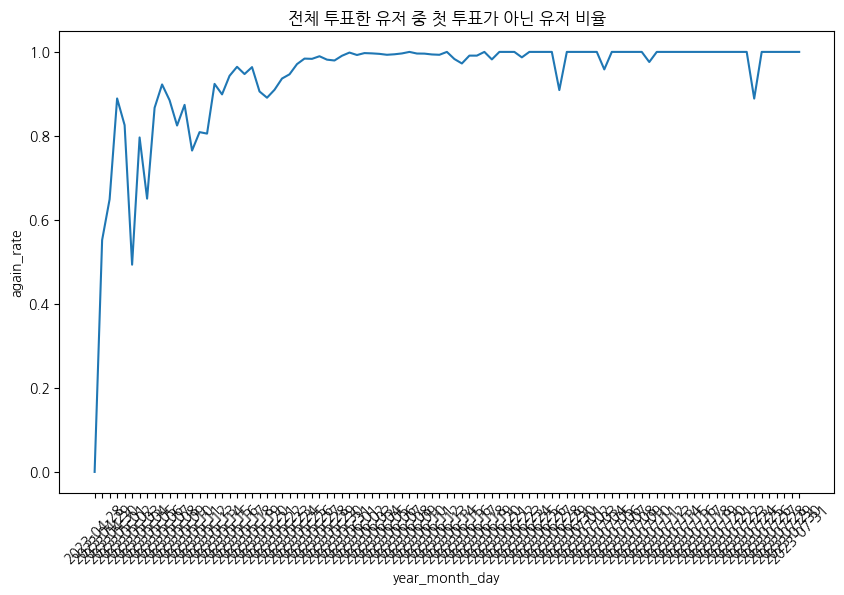

In [28]:
# 재방문 비율 시각화
plt.figure(figsize=(10,6))
sns.lineplot(data=user_cnt_df,  x='year_month_day', y='again_rate')
plt.title('전체 투표한 유저 중 첫 투표가 아닌 유저 비율')
plt.xticks(rotation=45)
plt.show()

In [29]:
# 1. 데이터 준비
df = grouped.copy()  

# 2. 각 유저의 첫 방문일 구하기 (Day 0 기준 만들기)
first_visit = df.groupby('user_id')['year_month_day'].min().reset_index()
first_visit.columns = ['user_id', 'first_day']

# 3. 원본 데이터에 Day 0 정보 붙이기
df = pd.merge(df, first_visit, on='user_id')

# 4. 각 row마다 Day N (몇일째 방문인지) 계산
df['day_number'] = (pd.to_datetime(df['year_month_day']) - pd.to_datetime(df['first_day'])).dt.days

# 5. 코호트 기준: 첫 방문일 기준으로 그룹핑
df['cohort'] = df['first_day']  # 또는 pd.to_datetime(df['first_day']).dt.strftime('%b %d') 형식도 가능

# 6. 코호트별로 각 Day에 방문한 유저 수 집계
retention = (
    df.groupby(['cohort', 'day_number'])['user_id']
    .nunique()
    .unstack(fill_value=0)
)

# 7. 각 코호트의 Day 0 유저 수로 나눠 비율(%) 계산
cohort_sizes = retention[0]
retention_rate = retention.divide(cohort_sizes, axis=0) * 100  # %로

# 8. 결과 확인
retention_rate = retention_rate.round(1)

In [30]:
retention_rate

day_number,0,1,2,3,4,5,6,7,8,9,...,335,338,342,344,345,357,360,364,369,375
cohort,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,48.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-29,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,45.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-04-30,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,54.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-01,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,30.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-02,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,43.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-03,100.0,90.6,92.2,87.7,82.2,68.4,60.8,50.1,42.3,33.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0
2023-05-04,100.0,92.8,90.4,83.8,63.5,55.7,49.7,41.9,33.5,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,33.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-06,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,24.6,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 시각화 

In [63]:
# 이상치 제거 하기
group_df = group_df[(group_df['grade'] <= 3) & (group_df['class_num'] <= 20) & (group_df['class_num'] > 0) ]

In [64]:
# school_id, group_id 테이블 합치기
school_group_df = pd.merge(group_df, school_df, left_on='school_id', right_on='id', how='left')
school_group_df = school_group_df.drop(columns=['class_num', 'id_y'])
school_group_df = school_group_df.rename(columns={'id_x':'group_id'})
school_group_df.head()

,group_id,grade,school_id,address,student_count,school_type
0,1,1,1,NaN,NaN,NaN
1,8,3,1,NaN,NaN,NaN
2,9,3,1,NaN,NaN,NaN
3,10,2,1,NaN,NaN,NaN
4,11,2,1,NaN,NaN,NaN


In [65]:
user_group_df = user_df[['id', 'group_id']]
user_school_df = pd.merge(user_group_df, school_group_df, on='group_id', how='left')
user_school_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,NaN,NaN,NaN,NaN,NaN,NaN
1,831962,12.0,2.0,1.0,NaN,NaN,NaN
2,832151,1.0,1.0,1.0,NaN,NaN,NaN
3,832340,1.0,1.0,1.0,NaN,NaN,NaN
4,832520,12.0,2.0,1.0,NaN,NaN,NaN


In [66]:
# 결측치를 0으로 채워서 사라지지 않게 하기
user_school_fillna_df = user_school_df.copy()
user_school_fillna_df = user_school_fillna_df.fillna(0)

In [67]:
# 투표 기록 테이블에 학교 정보 합치기
userquestion_school_df = pd.merge(userquestion_df, user_school_fillna_df, left_on='user_id', right_on='id', how='left')
userquestion_school_df.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,id_y,group_id,grade,school_id,address,student_count,school_type
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [68]:
# 필요없는 컬럼 삭제하기
userquestion_school_df = userquestion_school_df.drop(columns=['id_x','report_count', 'opened_times', 'id_y'])
userquestion_school_df.head()

,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,group_id,grade,school_id,address,student_count,school_type
0,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [69]:
# 학교 리스트 담기
school_list = list(userquestion_school_df['school_id'].unique())
school_list

[271.0, 4516.0, 369.0, 352.0, 1478.0, 5520.0, 5491.0, 5372.0, 1719.0, 4426.0]

In [70]:
# 10개 학교의 학생 수 
user_school_10_df = user_school_fillna_df[user_school_fillna_df['school_id'].isin(school_list)]
user_school_10_df['id'].nunique()

5090

In [71]:
# 학생 user_id 리스트에 담기
user_id_list = list(user_school_10_df['id'].unique())

In [72]:
# 유저 수 확인해보기
userquestion_school_df['user_id'].nunique()

4849

In [73]:
# 전체 user 데이터에서 학생들 user_id가 일치하는 것들만 남기기
user_target_df = user_df[user_df['id'].isin(user_id_list)]
user_target_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
396,838023,0,0,F,2456,"[855552, 861830, 859783, 850186, 868492, 85595...",1,2023-04-19 09:06:00.719792,[],[],N,0,1,0,115,233.0
633,838466,0,0,F,1680,"[876288, 869250, 873349, 867975, 878602, 11573...",1,2023-04-19 15:10:56.560337,[],[],N,0,1,0,244,321.0
756,838642,0,0,F,382,"[849928, 847375, 849938, 849946, 849436, 84943...",1,2023-04-20 00:11:00.962160,[],[],N,0,0,0,37,356.0
1252,839357,0,0,M,2299,"[855552, 857473, 861830, 866953, 867849, 86605...",1,2023-04-20 14:26:20.479856,[],[],N,0,1,0,52,519.0
1497,839670,0,0,F,643,"[871299, 850180, 850948, 849670, 851593, 84737...",0,2023-04-21 00:25:27.279382,[],[],N,0,1,0,24,603.0


In [74]:
# 연-월 컬럼 뽑기
user_target_df['year_month'] = user_target_df['created_at'].dt.strftime('%Y-%m')
user_target_df.head()


/tmp/ipykernel_1509767/2651649749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_target_df['year_month'] = user_target_df['created_at'].dt.strftime('%Y-%m')


,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,year_month
396,838023,0,0,F,2456,"[855552, 861830, 859783, 850186, 868492, 85595...",1,2023-04-19 09:06:00.719792,[],[],N,0,1,0,115,233.0,2023-04
633,838466,0,0,F,1680,"[876288, 869250, 873349, 867975, 878602, 11573...",1,2023-04-19 15:10:56.560337,[],[],N,0,1,0,244,321.0,2023-04
756,838642,0,0,F,382,"[849928, 847375, 849938, 849946, 849436, 84943...",1,2023-04-20 00:11:00.962160,[],[],N,0,0,0,37,356.0,2023-04
1252,839357,0,0,M,2299,"[855552, 857473, 861830, 866953, 867849, 86605...",1,2023-04-20 14:26:20.479856,[],[],N,0,1,0,52,519.0,2023-04
1497,839670,0,0,F,643,"[871299, 850180, 850948, 849670, 851593, 84737...",0,2023-04-21 00:25:27.279382,[],[],N,0,1,0,24,603.0,2023-04


In [75]:
# 월별 회원가입 유저 수 구하기
user_count_df = user_target_df.groupby(['year_month'])['id'].nunique().reset_index(name='monthly_user_cnt')
user_count_df.head()

,year_month,monthly_user_cnt
0,2023-04,403
1,2023-05,4632
2,2023-06,35
3,2023-07,4
4,2023-08,2


In [76]:
# 누적 회원 수 구하기
user_count_df['total_user'] = user_count_df['monthly_user_cnt'].cumsum()
user_count_df.head()

,year_month,monthly_user_cnt,total_user
0,2023-04,403,403
1,2023-05,4632,5035
2,2023-06,35,5070
3,2023-07,4,5074
4,2023-08,2,5076


In [77]:
# 연-월 컬럼 만들기
userquestion_school_df['year_month'] = userquestion_school_df['created_at'].dt.strftime('%Y-%m')

# 일별 투표자 수 구하기
daily_vote_user_cnt_df = userquestion_school_df.groupby(['year_month'])['user_id'].nunique().reset_index(name='monthly_vote_user_cnt')
daily_vote_user_cnt_df.head()

,year_month,monthly_vote_user_cnt
0,2023-04,338
1,2023-05,4797
2,2023-06,1872
3,2023-07,389
4,2023-08,170


In [78]:
# user_count_df 와 합치기
user_count_df = pd.merge(user_count_df, daily_vote_user_cnt_df, on='year_month',how='left')
user_count_df.head()

,year_month,monthly_user_cnt,total_user,monthly_vote_user_cnt
0,2023-04,403,403,338
1,2023-05,4632,5035,4797
2,2023-06,35,5070,1872
3,2023-07,4,5074,389
4,2023-08,2,5076,170


In [79]:
# 투표율 구하기
user_count_df['vote_rate'] = user_count_df['monthly_vote_user_cnt'] / user_count_df['total_user']
user_count_df.head()

,year_month,monthly_user_cnt,total_user,monthly_vote_user_cnt,vote_rate
0,2023-04,403,403,338,0.838710
1,2023-05,4632,5035,4797,0.952731
2,2023-06,35,5070,1872,0.369231
3,2023-07,4,5074,389,0.076665
4,2023-08,2,5076,170,0.033491


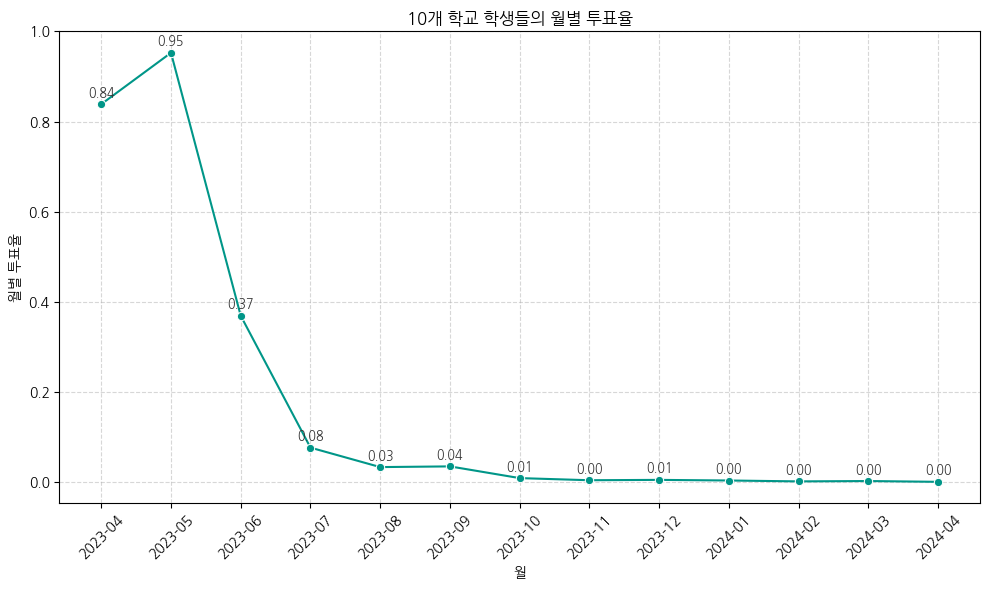

In [80]:
plt.figure(figsize=(10, 6))

# 선 색상 및 동그라미 표시
sns.lineplot(data=user_count_df, x='year_month', y='vote_rate', color='#009688', marker='o')

# 배경 그리드 추가
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# 포인트마다 수치 기재
for i in range(len(user_count_df)):
    x = user_count_df['year_month'].iloc[i]
    y = user_count_df['vote_rate'].iloc[i]
    plt.text(x, y + 0.01, f"{y:.2f}", ha='center', va='bottom', fontsize=9, color='#333')

# 제목 및 라벨
plt.title('10개 학교 학생들의 월별 투표율')
plt.xlabel('월')
plt.ylabel('월별 투표율')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Tableau 

In [31]:
user_df = pd.read_parquet('./votes/accounts_user.parquet')
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [32]:
user_4567_df = user_df[(user_df['created_at']>='2023-04-01')&(user_df['created_at']<'2023-08-01')]

In [33]:
userquestion_df = pd.read_parquet('./votes/accounts_userquestionrecord.parquet')
userquestion_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [34]:
userquestion_4567_df = userquestion_df[(userquestion_df['created_at']>='2023-04-01') & (userquestion_df['created_at']<'2023-08-01')]

In [35]:
school_df = pd.read_parquet('./votes/accounts_school.parquet')
school_df.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [36]:
group_df = pd.read_parquet('./votes/accounts_group.parquet')
group_df.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [37]:
# school_id, group_id 테이블 합치기
school_group_df = pd.merge(group_df, school_df, left_on='school_id', right_on='id', how='left')
school_group_df = school_group_df.drop(columns=['class_num', 'id_y'])
school_group_df = school_group_df.rename(columns={'id_x':'group_id'})
school_group_df.head()

,group_id,grade,school_id,address,student_count,school_type
0,1,1,1,NaN,NaN,NaN
1,8,3,1,NaN,NaN,NaN
2,9,3,1,NaN,NaN,NaN
3,10,2,1,NaN,NaN,NaN
4,11,2,1,NaN,NaN,NaN


In [38]:
user_group_df = user_df[['id', 'group_id']]
user_school_df = pd.merge(user_group_df, school_group_df, on='group_id', how='left')
user_school_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,NaN,NaN,NaN,NaN,NaN,NaN
1,831962,12.0,2.0,1.0,NaN,NaN,NaN
2,832151,1.0,1.0,1.0,NaN,NaN,NaN
3,832340,1.0,1.0,1.0,NaN,NaN,NaN
4,832520,12.0,2.0,1.0,NaN,NaN,NaN


In [39]:
#  투표 기록 테이블에서 user_id, school_id 모두 합치기
# 필요한 컬럼만 뽑기
userquestion_4567_df = userquestion_4567_df[['id', 'status', 'created_at', 'chosen_user_id', 'question_id', 'user_id', 'question_piece_id', 'has_read', 'answer_status']]
# user_id, school_id 모두 합치기
user_question_school_df = pd.merge(userquestion_4567_df, user_school_df, left_on='user_id', right_on='id', how='left')
user_question_school_df.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,id_y,group_id,grade,school_id,address,student_count,school_type
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [40]:
user_question_school_list = list(user_question_school_df['school_id'].unique())
user_question_school_list

[271.0, 4516.0, 369.0, 352.0, 1478.0, 5520.0, 5491.0, 5372.0, 1719.0, 4426.0]

In [41]:
# 4~7월 가입 유저들과 학교 id 합치기
user_school_4567_df = pd.merge(user_4567_df, school_group_df, on='group_id', how='left')
user_school_4567_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,...,report_count,alarm_count,pending_chat,pending_votes,group_id,grade,school_id,address,student_count,school_type
0,833673,0,0,F,2728,"[1450116, 858760, 848400, 935440, 842386, 8428...",1,2023-04-01 00:16:13.335620,[],"[843069, 846728, 849023, 841101, 844009, 84883...",...,0,0,0,240,101.0,1.0,289.0,충청남도 천안시 서북구,385.0,H
1,833714,0,0,F,612,"[866817, 1141773, 849421, 863249, 841243, 8468...",0,2023-04-01 00:16:13.342433,[],[],...,0,1,0,235,41.0,1.0,272.0,충청남도 천안시 서북구,339.0,H
2,833729,0,0,M,58,"[841089, 849538, 873737, 845325, 869517, 84456...",1,2023-04-01 00:20:36.236260,[],[],...,0,0,0,27,42.0,1.0,272.0,충청남도 천안시 서북구,339.0,H
3,833763,0,0,F,2738,"[1512834, 1359367, 1418504, 901641, 1422088, 1...",1,2023-04-01 00:24:59.710901,[],[],...,0,3,0,224,52.0,1.0,4523.0,경기도 화성시,92.0,H
4,833798,0,0,F,2250,"[850560, 869508, 848139, 1334027, 897549, 8739...",1,2023-04-01 01:15:21.070606,[],[],...,0,0,0,81,53.0,2.0,272.0,충청남도 천안시 서북구,339.0,H


In [42]:
# 4~7월 가입자의 학교 수
user_school_4567_df['school_id'].nunique()

5537

- 투표율 구하기

In [43]:
# 해당 학생들로만 데이터 분석하기 위해서 user_id 리스트로 뽑기
user_list = list(user_question_school_df['user_id'].unique())
user_list

[849436,
 847375,
 849438,
 849479,
 849441,
 849452,
 849469,
 849439,
 849634,
 849489,
 849493,
 849692,
 849445,
 849670,
 849477,
 849762,
 849487,
 849475,
 849559,
 849864,
 849454,
 849446,
 849504,
 849566,
 849503,
 849471,
 849443,
 849558,
 849620,
 849497,
 849444,
 849543,
 849922,
 849466,
 849464,
 849442,
 849450,
 849103,
 849946,
 849451,
 849488,
 849490,
 849981,
 849983,
 849995,
 849974,
 850007,
 850006,
 849460,
 850039,
 850031,
 850058,
 850057,
 850077,
 849549,
 850091,
 850098,
 849498,
 849979,
 849548,
 849502,
 849512,
 850150,
 850112,
 850130,
 850173,
 850180,
 850186,
 849938,
 850195,
 850152,
 849535,
 850208,
 850212,
 850217,
 850215,
 849928,
 850248,
 850255,
 850229,
 849963,
 850267,
 850269,
 838642,
 850334,
 850344,
 850378,
 850303,
 849541,
 850429,
 850249,
 850127,
 850475,
 850457,
 850284,
 850102,
 850319,
 850388,
 850435,
 850554,
 850556,
 849453,
 850392,
 850412,
 849486,
 849515,
 850413,
 850615,
 850610,
 850633,
 850668,
 

- 누적 회원가입 수 구하기

In [44]:
# 누적 회원가입 구하기 위해서 우선 필요한 컬럼만 뽑기
user_join_df =  user_df[['id', 'created_at']]
user_join_df.head()

,id,created_at
0,831956,2023-03-29 03:44:14.047130
1,831962,2023-03-29 05:18:56.162368
2,832151,2023-03-29 12:56:34.989468
3,832340,2023-03-29 12:56:35.020790
4,832520,2023-03-29 12:56:35.049311


In [45]:
# 10개 학교 학생들로만 구성되도록 데이터 정제하기
user_join_df = user_join_df[user_join_df['id'].isin(user_list)]
# 연-월-일 컬럼 뽑기
user_join_df['year_month_day'] = user_join_df['created_at'].dt.strftime('%Y-%m-%d')
user_join_df.head()

,id,created_at,year_month_day
396,838023,2023-04-19 09:06:00.719792,2023-04-19
633,838466,2023-04-19 15:10:56.560337,2023-04-19
756,838642,2023-04-20 00:11:00.962160,2023-04-20
1252,839357,2023-04-20 14:26:20.479856,2023-04-20
1889,840293,2023-04-21 11:45:56.750174,2023-04-21


In [46]:
# 일별 회원가입 수 확인
user_join_cnt_df = user_join_df.groupby(['year_month_day'])['id'].nunique().reset_index(name='daily_join_cnt')
# 누적 회원 수 컬럼 생성
user_join_cnt_df['total_user'] = user_join_cnt_df['daily_join_cnt'].cumsum()
user_join_cnt_df.head()
# 5~7월만 보기
# user_join_cnt_df = user_join_cnt_df[(user_join_cnt_df['year_month_day'] >= '2023-05-01') & (user_join_cnt_df['year_month_day'] < '2023-08-01')]
# user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user
0,2023-04-19,2,2
1,2023-04-20,2,4
2,2023-04-21,5,9
3,2023-04-22,4,13
4,2023-04-24,5,18


In [47]:
# 연-월-일 컬럼 생성
user_question_school_df['year_month_day'] = user_question_school_df['created_at'].dt.strftime('%Y-%m-%d')
# 일별 투표자 수
daily_question_df = user_question_school_df.groupby(['year_month_day'])['user_id'].nunique()
daily_question_df.head()

year_month_day
2023-04-28    125
2023-04-29    221
2023-04-30    325
2023-05-01    325
2023-05-02    413
Name: user_id, dtype: int64

In [48]:
# 데이터프레임 형태로 만들어서 합치기
daily_question_df = daily_question_df.reset_index(name='daily_question_user_cnt')

user_join_cnt_df = pd.merge(user_join_cnt_df, daily_question_df,on='year_month_day', how='left')
user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt
0,2023-04-19,2,2,NaN
1,2023-04-20,2,4,NaN
2,2023-04-21,5,9,NaN
3,2023-04-22,4,13,NaN
4,2023-04-24,5,18,NaN


In [49]:
# 일별 투표율 구하기
user_join_cnt_df['vote_rate'] = user_join_cnt_df['daily_question_user_cnt'] / user_join_cnt_df['total_user']
user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate
0,2023-04-19,2,2,NaN,NaN
1,2023-04-20,2,4,NaN,NaN
2,2023-04-21,5,9,NaN,NaN
3,2023-04-22,4,13,NaN,NaN
4,2023-04-24,5,18,NaN,NaN


In [50]:
# 기간 4/28 ~ 7/31 으로 자르기
user_join_cnt_df = user_join_cnt_df[(user_join_cnt_df['year_month_day'] >= '2023-04-28')&(user_join_cnt_df['year_month_day'] < '2023-08-01')]
user_join_cnt_df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate
8,2023-04-28,139,160,125.0,0.781250
9,2023-04-29,116,276,221.0,0.800725
10,2023-04-30,118,394,325.0,0.824873
11,2023-05-01,41,435,325.0,0.747126
12,2023-05-02,97,532,413.0,0.776316


In [51]:
# 수민님이 만든 첫 투표까지 걸린 시간 데이터 불러오기
first_vote_df = pd.read_csv("./time_to_first_vote.csv")
first_vote_df.head()

,user_id,first_vote_date,sign_up_date,days_to_vote_hours,days_to_vote_mins
0,849436,2023-04-28 12:27:49,2023-04-28 02:54:59.981972,0 days 09:00:00,0 days 09:32:00
1,847375,2023-04-28 12:28:46,2023-04-26 11:32:36.470049,2 days 00:00:00,2 days 00:56:00
2,849438,2023-04-28 12:29:29,2023-04-28 02:56:02.571340,0 days 09:00:00,0 days 09:33:00
3,849479,2023-04-28 12:29:52,2023-04-28 03:27:32.406440,0 days 09:00:00,0 days 09:02:00
4,849441,2023-04-28 12:30:06,2023-04-28 02:56:56.323854,0 days 09:00:00,0 days 09:33:00


In [52]:

# 문자열을 datetime 형식으로 변환
first_vote_df['first_vote_date'] = pd.to_datetime(first_vote_df['first_vote_date'])
first_vote_df['sign_up_date'] = pd.to_datetime(first_vote_df['sign_up_date'])

# 연-월-일 변환
first_vote_df['first_vote_day'] = first_vote_df['first_vote_date'].dt.strftime('%Y-%m-%d')
first_vote_df['sign_up_day'] = first_vote_df['sign_up_date'].dt.strftime('%Y-%m-%d')
first_vote_df.head()

,user_id,first_vote_date,sign_up_date,days_to_vote_hours,days_to_vote_mins,first_vote_day,sign_up_day
0,849436,2023-04-28 12:27:49,2023-04-28 02:54:59.981972,0 days 09:00:00,0 days 09:32:00,2023-04-28,2023-04-28
1,847375,2023-04-28 12:28:46,2023-04-26 11:32:36.470049,2 days 00:00:00,2 days 00:56:00,2023-04-28,2023-04-26
2,849438,2023-04-28 12:29:29,2023-04-28 02:56:02.571340,0 days 09:00:00,0 days 09:33:00,2023-04-28,2023-04-28
3,849479,2023-04-28 12:29:52,2023-04-28 03:27:32.406440,0 days 09:00:00,0 days 09:02:00,2023-04-28,2023-04-28
4,849441,2023-04-28 12:30:06,2023-04-28 02:56:56.323854,0 days 09:00:00,0 days 09:33:00,2023-04-28,2023-04-28


In [53]:
# 회원가입일에 첫 투표한 유저만 뽑기

first_vote_same_df = first_vote_df[(first_vote_df['first_vote_day'] == first_vote_df['sign_up_day'])]
first_vote_same_df.head()

,user_id,first_vote_date,sign_up_date,days_to_vote_hours,days_to_vote_mins,first_vote_day,sign_up_day
0,849436,2023-04-28 12:27:49,2023-04-28 02:54:59.981972,0 days 09:00:00,0 days 09:32:00,2023-04-28,2023-04-28
2,849438,2023-04-28 12:29:29,2023-04-28 02:56:02.571340,0 days 09:00:00,0 days 09:33:00,2023-04-28,2023-04-28
3,849479,2023-04-28 12:29:52,2023-04-28 03:27:32.406440,0 days 09:00:00,0 days 09:02:00,2023-04-28,2023-04-28
4,849441,2023-04-28 12:30:06,2023-04-28 02:56:56.323854,0 days 09:00:00,0 days 09:33:00,2023-04-28,2023-04-28
5,849452,2023-04-28 12:30:40,2023-04-28 03:09:51.662807,0 days 09:00:00,0 days 09:20:00,2023-04-28,2023-04-28


In [54]:
first_vote_same_df = first_vote_same_df.groupby(['first_vote_day'])['user_id'].nunique().reset_index(name='first_vote_same_signup_count')

In [55]:
# 최종 데이터 합치기

df = pd.merge(user_join_cnt_df, first_vote_same_df, left_on='year_month_day', right_on='first_vote_day', how='left')
df.head()

,year_month_day,daily_join_cnt,total_user,daily_question_user_cnt,vote_rate,first_vote_day,first_vote_same_signup_count
0,2023-04-28,139,160,125.0,0.781250,2023-04-28,122.0
1,2023-04-29,116,276,221.0,0.800725,2023-04-29,83.0
2,2023-04-30,118,394,325.0,0.824873,2023-04-30,100.0
3,2023-05-01,41,435,325.0,0.747126,2023-05-01,27.0
4,2023-05-02,97,532,413.0,0.776316,2023-05-02,55.0


---

- 일자별 친구 요청수

In [56]:
friendrequest_df = pd.read_parquet('./votes/accounts_friendrequest.parquet')
friendrequest_df.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [57]:
# 일자별 요청 수 확인하기

# 연-월-일 만들기
friendrequest_df['year_month_day'] = friendrequest_df['created_at'].dt.strftime('%Y-%m-%d')

# 10개 학교 유저 자르기
friendrequest_df = friendrequest_df[friendrequest_df['send_user_id'].isin(user_list)]

# 4/28 ~ 7/31 기간 자르기
friendrequest_df = friendrequest_df[(friendrequest_df['year_month_day']>='2023-04-28')&(friendrequest_df['year_month_day']<'2023-08-01')]

# 그룹화하기
friendrequest_dailycnt_df = friendrequest_df.groupby(['year_month_day', 'send_user_id']).size().reset_index(name='friendrequest_count')
friendrequest_dailycnt_df.head()

,year_month_day,send_user_id,friendrequest_count
0,2023-04-28,847375,27
1,2023-04-28,849103,2
2,2023-04-28,849436,20
3,2023-04-28,849438,42
4,2023-04-28,849439,15


In [58]:
result_df = (
    friendrequest_dailycnt_df
    .groupby('year_month_day')
    .agg({ 
        'send_user_id': 'count',
        'friendrequest_count': 'mean'
    })
)

result_df.head()

,send_user_id,friendrequest_count
year_month_day,,
2023-04-28,137,17.087591
2023-04-29,194,10.979381
2023-04-30,190,12.642105
2023-05-01,129,8.131783
2023-05-02,187,7.026738


In [59]:
result_df = result_df[result_df['send_user_id']>=30]

In [60]:
result_df = result_df.reset_index()

In [61]:
daily_avg_friendrequest_df = friendrequest_dailycnt_df.groupby(['year_month_day'])['friendrequest_count'].mean().reset_index(name='daily_avg_friendrequest')

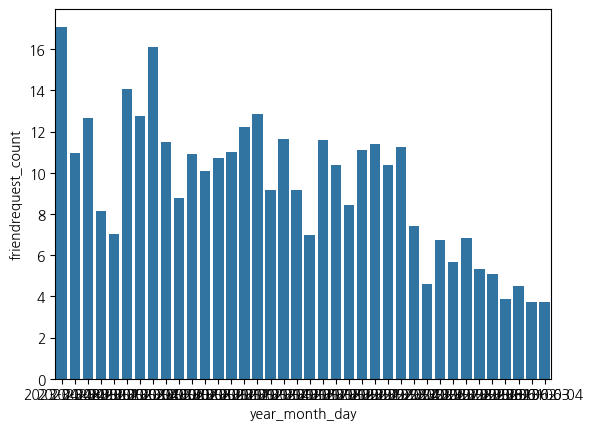

In [62]:
# 시각화 
sns.barplot(data=result_df, x='year_month_day', y='friendrequest_count')
plt.show()

---